# Learning linear conservative system using a symplectic neural network

In this notebook we will use a structure-preserving neural network to learn a function $\phi:\mathbb{R}^{2n}\rightarrow\mathbb{R}^{2n}$ from a data set.

We know that the unknown function $\phi$ is the solution of linear conservative ODE $\dot{x} = JMx$, where $J=-J^T$ is a symplectic matrix and $M=M^T$ is a symmetric matrix. 

The data therefore has the property of being generated by a symplectic transformation, meaning that the map $\phi$ satisfies the following relationship 
$$\frac{\partial\phi(x)}{\partial x}J\frac{\partial\phi(x)}{\partial x}^T=J$$

We will exploit this knowledge by learning the map using a symplectic neural network (SympNet). A SympNet is a neural network, which we will denote by $\mathcal{N}:\mathbb{R}^{2n}\rightarrow\mathbb{R}^{2n}$ that, by construction satifies the above symplectic condition, that is: 
$$\frac{\partial\mathcal{N}(x)}{\partial x}J\frac{\partial\mathcal{N}(x)}{\partial x}^T=J.$$

The advantage of doing so means that the hypothesis space of the neural network $\mathcal{N}$ is significantly smaller than that of a generic (non-structure-preserving) neural network, allowing us to learn frmo high dimensional data much more efficiently. 

In this notebook, we will generate some data from a linear symplectic transformation (i.e., an ordinary differential equation with a quadratic Hamiltonian) then learn its dynamics with a SympNet. 

In [14]:
import torch 

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate data 

We will generate data of the form $\{x_i, \phi(x_i)\}_{i=1}^m$, where the $x_i\in\mathbb{R}^{2n}$ are generated randomly in the hypercube $[-1, 1]^{2n}$. The dimension of the data is $2n$ (it has to be even), where `DIM = n` is a parameter you can change in the code below. 

The function `generate_linear_hamiltonian_data` returns two tensors `x0` and `x1`, where `x1` is the map $\phi$ applied to `x0`. 



In [8]:
from utils import generate_linear_hamiltonian_data

DIM = 32
TIMESTEP = torch.tensor([0.05])
NDATA = 200

x0, x1 = generate_linear_hamiltonian_data(
    dim=DIM, 
    ndata=NDATA, 
    timestep=TIMESTEP,
    device=device,
)

### Initialize the Hamiltonian neural network (P-SympNet) using the StruPNET package

In [9]:
from strupnet import SympNet

sympnet = SympNet(
    dim=DIM,
    max_degree=2,
    layers=2*DIM,
    method='P',
)

### Train the Hamiltonian neural network using the Adams optimiser

 68%|██████▊   | 680/1000 [00:07<00:03, 95.67it/s, train_loss=1e-14, best_train_loss=1e-14]      


Final loss value:  9.985930212517106e-15


ValueError: Input could not be cast to an at-least-1D NumPy array

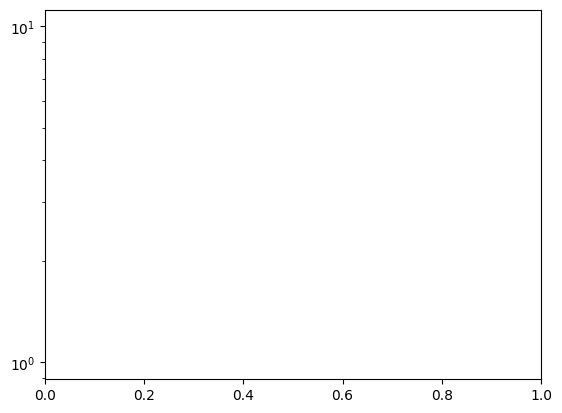

In [10]:
from utils import train
import matplotlib.pyplot as plt

NEPOCHS = 1000
LEARNING_RATE = 0.05
WEIGHT_DECAY = 0.0

training_curve = train(
    net=sympnet,
    x0=x0,
    x1=x1,
    lr=LEARNING_RATE,
    nepochs=NEPOCHS,
    timestep=TIMESTEP,
    tol=1e-14,
    weight_decay=WEIGHT_DECAY,
    use_best_train_loss=True, 
)

plt.semilogy(training_curve)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss curve')
plt.show()


### Compare the prediction with the true solution

GIF saved as prediction.gif


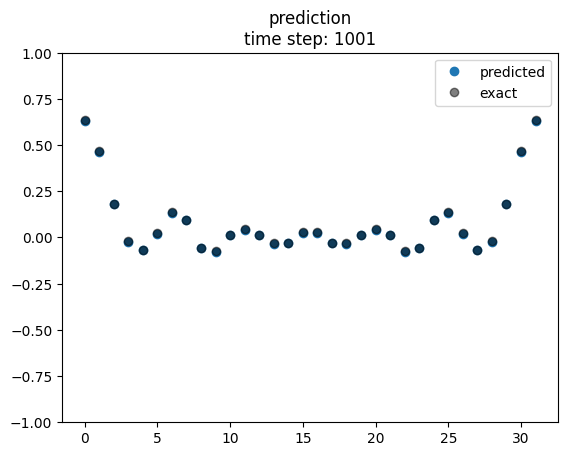

In [13]:
from utils import create_gif, generate_linear_hamiltonian_trajectory

NSTEPS = 1000

# Initial conditions
z = torch.linspace(-1, 1, DIM)
p0, q0 = torch.zeros(DIM), torch.exp(-z**2*100)

# True solution
true_sol = generate_linear_hamiltonian_trajectory(p0, q0, TIMESTEP, NSTEPS)

# Predicted solution
pred_sol = torch.zeros(NSTEPS + 1, 2*DIM)
pred_sol[0, :] = true_sol[0, :]
for i in range(NSTEPS):
    pred_sol[i+1, :] = sympnet(x=pred_sol[i, :], dt=TIMESTEP).detach()

create_gif(pred_sol[:, DIM:], exact_solution=true_sol[:, DIM:], title='prediction', duration=0.00001)
